In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [2]:
import hddm
import numpy as np
import seaborn as sns
import os
import pandas as pd
from textwrap import wrap
# from jupyterthemes import jtplot
import matplotlib.pyplot as plt
%matplotlib inline

/home/kbond/.conda/envs/hddm_outside_slurm/lib/python2.7/site-packages/IPython/parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated since IPython 4.0. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)


In [3]:
sns.set_color_codes("muted")

In [4]:
home = '/lab_data/coaxlab/Projects/dynamic_decision_policy_reconfiguration/'
write_dir = os.path.join(home, 'analysis_revision/loki0.5_acc_av_models/subset_regression/')
print(write_dir)

/lab_data/coaxlab/Projects/dynamic_decision_policy_reconfiguration/analysis_revision/loki0.5_acc_av_models/subset_regression/


In [5]:
# all_obs_data = hddm.load_csv(os.path.join(home, 'aggregated_data/loki_0.5/av_manifold_df_2.csv'))
# all_obs_data_pared = all_obs_data.loc[(all_obs_data.shifted_epoch_trial <= 3) &
#                                       (all_obs_data.shifted_epoch_trial >=-1)]

In [6]:
all_obs_data_pared_input = pd.read_csv(os.path.join(home, 'analysis_revision/loki0.5_acc_av_models/', 'loki_0.5_1_beh_data.csv'))

In [7]:
all_obs_data_pared_input.head()

,response,rt,condition,subj_idx,shifted_epoch_trial,p_optimal,lambda_val,cpp,ideal_B,trial
0,1.0,0.474282,6510,786,1.0,0.65,10.0,0.076938,-2.160816,1
1,1.0,0.500100,6510,786,2.0,0.65,10.0,0.319389,-1.562444,2
2,1.0,0.534169,6510,786,3.0,0.65,10.0,0.300755,0.125126,3
3,1.0,0.630004,6510,786,-1.0,0.65,10.0,0.077553,2.206471,13
4,1.0,0.596382,6510,786,0.0,0.65,10.0,0.463273,-2.664951,14


In [21]:
all_obs_data_pared_input.groupby(['subj_idx', 'condition']).count()

response   rt  shifted_epoch_trial  p_optimal  lambda_val  \
subj_idx condition                                                              
786      6510            186  186                  186        186         186   
         6520             93   93                   93         93          93   
         6530             63   63                   63         63          63   
         7510            171  171                  171        171         171   
         7520             99   99                   99         99          99   
         7530             67   67                   67         67          67   
         8510            181  181                  181        181         181   
         8520             89   89                   89         89          89   
         8530             62   62                   62         62          62   
787      6510            189  189                  189        189         189   
         6520             97   97                   97         97          97   
         6530             67   67                   67         67          67   
         7510            176  176                  176        176         176   
         7520             92   92                   92         92          92   
         7530             69   69                   69         69          69   
         8510            191  191                  191        191         191   
         8520             96   96                   96         96          96   
         8530             64   64                   64         64          64   
788      6510            195  195                  195        195         195   
         6520            103  103                  103        103         103   
         6530             66   66                   66         66          66   
         7510            182  182                  182        182         182   
         7520            103  103                  103        103         103   
         7530             64   64                   64         64          64   
         8510            188  188                  188        188         188   
         8520             92   92                   92         92          92   
         8530             69   69                   69         69          69   
789      6510            189  189                  189        189         189   
         6520             94   94                   94         94          94   
         6530             69   69                   69         69          69   
...                      ...  ...                  ...        ...         ...   
790      8510            133  133                  133        133         133   
         8520             73   73                   73         73          73   
         8530             52   52                   52         52          52   
811      6510            144  144                  144        144         144   
         6520             70   70                   70         70          70   
         6530             50   50                   50         50          50   
         7510            142  142                  142        142         142   
         7520             71   71                   71         71          71   
         7530             42   42                   42         42          42   
         8510            142  142                  142        142         142   
         8520             65   65                   65         65          65   
         8530             50   50                   50         50          50   
813      6510            133  133                  133        133         133   
         6520             69   69                   69         69          69   
         6530             54   54                   54         54          54   
         7510            143  143                  143        143         143   
         7520             78   78                  

In [8]:
# all_obs_data_pared = all_obs_data_pared.rename(index=str, columns={"p_accuracy": "response",
#                                                        "subj_id": "subj_idx"})
# all_obs_data_pared = all_obs_data_pared[['response', 'rt', 'reward_code', 'subj_idx','condition',
#                                          'ideal_B', 'cpp', 
#                              'shifted_epoch_trial', 'session_n']] 
# all_obs_data_pared.reset_index(drop=True, inplace=True)

In [9]:
all_obs_data_pared_input['cpp_shifted'] = all_obs_data_pared_input.groupby(['subj_idx', 'condition']).cpp.apply(lambda x: x.shift(1))
all_obs_data_pared_input['ideal_B_shifted'] = all_obs_data_pared_input.groupby(['subj_idx', 'condition']).ideal_B.apply(lambda x: x.shift(1))

In [10]:
# all_obs_data_pared.dropna(inplace=True) #need to drop nas for HDDMRegressor

In [15]:
# n_samples, n_burn = 10000, 1000

n_samples, n_burn = 5000, 500
# n_samples, n_burn = 10, 1
n_effective_samples = n_samples - n_burn
subjects = all_obs_data_pared_input.subj_idx.unique()

model_specifications = [('a~cpp_shifted', 'v~ideal_B_shifted'),
                        ('v~cpp_shifted', 'a~ideal_B_shifted'),
          ('a~1', 'v~1')]

# model_specifications = [('a~C(session_n)+cpp_shifted', 'v~C(session_n)+ideal_B_shifted'),
#                         ('a~C(session_n)+ideal_B_shifted', 'v~C(session_n)+cpp_shifted'),  
#                         ('a~1', 'v~1')]

model_names = ['a_cpp_v_B', 'v_cpp_a_B', 'intercept']

model_inputs = dict(zip(model_names, model_specifications))
model_objects = dict()

In [16]:
print(subjects)

[786 787 788 789 790 811 813 860]


In [17]:
def estimate_regression_model(model_specification, model_name, subject, data, model_objects,
                              n_samples=n_samples, n_burn=n_burn, accuracy_coding=True, convergence_iteration=None):
    
    if accuracy_coding: 
        reg_model = hddm.HDDMRegressor(data = data, models = model_specification,
                                       bias=True, group_only_regressors=False, 
                                       p_outlier=0.05, keep_regressor_trace=True) # accuracy coded
        reg_model.find_starting_values() # never runs if i include this?
        reg_model.sample(n_samples, burn = n_burn, dbname = model_name, db='pickle')
    else: 
        reg_model = hddm.HDDMRegressor(data = data, models = model_specification, bias=True, group_only_regressors=True, p_outlier=0.05) #stim coded
        reg_model.find_starting_values()
        reg_model.sample(n_samples, burn=n_burn, dbname = model_name + '_' + str(subject) + '.db', db='pickle')
    
    if convergence_iteration is None: 
        model_objects[model_name + '_' + str(subject)] = reg_model
    else:
        model_objects[model_name + '_' + str(subject) + '_iter' + str(convergence_iteration)] = reg_model

In [18]:
subject = 'all_subs'

for model_name, model_specification in model_inputs.items(): 
    estimate_regression_model(model_specification, model_name, subject, all_obs_data_pared_input, model_objects)
    print('model sampling complete')

Adding these covariates:
['a_Intercept']
Adding these covariates:
['v_Intercept']
 [-----------------100%-----------------] 5000 of 5000 complete in 2045.8 secmodel sampling complete
Adding these covariates:
['v_Intercept', 'v_cpp_shifted']
Adding these covariates:
['a_Intercept', 'a_ideal_B_shifted']
After 7.000000 retries, still no good fit found.


ValueError: Shape of passed values is (1002, 1), indices imply (1011, 1)

In [ ]:
# for subject in subjects:
#     sub_data = all_obs_data_pared.loc[all_obs_data_pared.subj_idx == subject,]
#     for model_name, model_specification in model_inputs.items(): 
#         estimate_regression_model(model_specification, model_name, subject, sub_data, model_objects)
#         print('model sampling complete')

In [ ]:
locals().update(model_objects) # convert keys and values to variables 

In [ ]:
model_objects

In [ ]:
dic_dict = {'a_cpp_v_B': a_cpp_v_B_all_subs.dic_info, 'v_cpp_a_B': v_cpp_a_B_all_subs.dic_info, 'intercept': intercept_all_subs.dic_info}

In [ ]:
for m in model_objects: 
    model_objects[m].plot_posteriors()

In [ ]:
model_objects

In [ ]:
dic_df = pd.DataFrame(dic_dict).transpose().reset_index()

In [ ]:
dic_df.rename({'index': 'model'}, axis=1, inplace=True)

In [ ]:
dic_df.head()

In [ ]:
model_dict = {'a_cpp_v_B': a_cpp_v_B_all_subs, 'v_cpp_a_B': v_cpp_a_B_all_subs, 'intercept': intercept_all_subs}
n_models = len(model_dict)

In [ ]:
# a_cpp_v_B_all_subs.get_traces().to_csv(os.path.join(write_dir, 'a_cpp_v_B_model_traces_sessions.csv'), index=False)

In [ ]:
a_cpp_v_B_all_subs = pd.read_csv(os.path.join(write_dir, 'a_cpp_v_B_model_traces_sessions.csv'))

In [ ]:
a_cpp_v_B_all_subs.head()

# Group-level CP-evoked $\hat{\beta}$ (trials -1:3)

In [ ]:
plt.figure(figsize=(10,8))
sns.set_context("talk", font_scale=1.3)
plt.hist(a_cpp_v_B_all_subs['a_cpp_shifted'], alpha=0.6)
plt.xlabel(r'$\hat{\beta}_{a\textasciitilde\Omega}$')
plt.axvline(x=0, color='black')
sns.despine(bottom=True, left=True)
plt.title("\n".join(wrap("E2: CP-evoked decision boundary change as a function of change point prob.", 60)), y=1.03)
plt.tight_layout()


plt.savefig(os.path.join(write_dir, 'CP_evoked_boundary_beta_posterior.pdf'), bbox_inches='tight')

In [ ]:
grp_a_session_traces = a_cpp_v_B_all_subs[['a_Intercept','a_C(session_n)[T.2]', 'a_C(session_n)[T.3]','a_C(session_n)[T.4]',
                   'a_C(session_n)[T.5]','a_C(session_n)[T.6]','a_C(session_n)[T.7]',
                   'a_C(session_n)[T.8]','a_C(session_n)[T.9]']]

In [135]:
grp_v_session_traces = a_cpp_v_B_all_subs[['v_Intercept', 'v_C(session_n)[T.2]', 'v_C(session_n)[T.3]','v_C(session_n)[T.4]',
                   'v_C(session_n)[T.5]','v_C(session_n)[T.6]','v_C(session_n)[T.7]',
                   'v_C(session_n)[T.8]','v_C(session_n)[T.9]']]

In [145]:
sub_traces = a_cpp_v_B_all_subs.columns[a_cpp_v_B_all_subs.columns.str.contains(pat = 'subj.')] 



In [149]:
a_cpp_v_B_all_subs[sub_traces].to_csv(os.path.join(write_dir, 'a_cpp_v_B_model_traces_sessions_subs.csv'), index=False)

In [150]:
a_cpp_v_B_all_sub_traces = a_cpp_v_B_all_subs[sub_traces]

In [162]:
a_sub_traces = a_cpp_v_B_all_sub_traces.columns[a_cpp_v_B_all_sub_traces.columns.str.contains(pat = 'a_C')] 
v_sub_traces = a_cpp_v_B_all_sub_traces.columns[a_cpp_v_B_all_sub_traces.columns.str.contains(pat = 'v_C')] 

In [224]:
v_sub_B_traces = a_cpp_v_B_all_sub_traces.columns[a_cpp_v_B_all_sub_traces.columns.str.contains(pat = 'v_ideal_B_shifted')]
a_sub_cpp_traces = a_cpp_v_B_all_sub_traces.columns[a_cpp_v_B_all_sub_traces.columns.str.contains(pat = 'a_cpp_shifted')]

In [290]:
sub_intercept_traces = a_cpp_v_B_all_sub_traces.columns[a_cpp_v_B_all_sub_traces.columns.str.contains(pat = 'Intercept')]

In [291]:
sub_intercept_traces_df = a_cpp_v_B_all_sub_traces[sub_intercept_traces]

In [292]:
sub_intercept_traces_df.columns

Index([u'a_Intercept_subj.786', u'a_Intercept_subj.787',
       u'a_Intercept_subj.788', u'a_Intercept_subj.789',
       u'v_Intercept_subj.786', u'v_Intercept_subj.787',
       u'v_Intercept_subj.788', u'v_Intercept_subj.789'],
      dtype='object')

In [293]:
sub_intercept_traces_df_melted = sub_intercept_traces_df.melt(var_name='node', value_name='intercept' )

In [294]:
sub_intercept_traces_df_melted.head()

,node,intercept
0,a_Intercept_subj.786,1.339635
1,a_Intercept_subj.786,1.372450
2,a_Intercept_subj.786,1.333566
3,a_Intercept_subj.786,1.351318
4,a_Intercept_subj.786,1.351520


In [295]:
sub_intercept_traces_df_melted.node.str.split(pat='_Intercept.', expand=True)

,0,1
0,a,subj.786
1,a,subj.786
2,a,subj.786
3,a,subj.786
4,a,subj.786
5,a,subj.786
6,a,subj.786
7,a,subj.786
8,a,subj.786
9,a,subj.786


In [296]:
sub_intercept_traces_df_melted['subj_idx'] = sub_intercept_traces_df_melted.node.str.split(pat='_subj.', expand=True)[1]

sub_intercept_traces_df_melted['parameter'] = sub_intercept_traces_df_melted.node.str.split(pat='_Intercept.', expand=True)[0]

sub_intercept_traces_df_melted.drop(columns='node', inplace=True)

In [297]:
sub_intercept_traces_df_melted.parameter

0        a
1        a
2        a
3        a
4        a
5        a
6        a
7        a
8        a
9        a
10       a
11       a
12       a
13       a
14       a
15       a
16       a
17       a
18       a
19       a
20       a
21       a
22       a
23       a
24       a
25       a
26       a
27       a
28       a
29       a
        ..
71970    v
71971    v
71972    v
71973    v
71974    v
71975    v
71976    v
71977    v
71978    v
71979    v
71980    v
71981    v
71982    v
71983    v
71984    v
71985    v
71986    v
71987    v
71988    v
71989    v
71990    v
71991    v
71992    v
71993    v
71994    v
71995    v
71996    v
71997    v
71998    v
71999    v
Name: parameter, Length: 72000, dtype: object

In [298]:
sub_intercept_traces_df_melted.to_csv(os.path.join(write_dir, 'sub_intercept_traces.csv'))

In [ ]:
a_sub_traces = a_cpp_v_B_all_sub_traces.columns[a_cpp_v_B_all_sub_traces.columns.str.contains(pat = 'a_C')] 
v_sub_traces = a_cpp_v_B_all_sub_traces.columns[a_cpp_v_B_all_sub_traces.columns.str.contains(pat = 'v_C')] 

In [163]:
sub_a_session_traces = a_cpp_v_B_all_sub_traces[a_sub_traces]

In [164]:
sub_v_session_traces = a_cpp_v_B_all_sub_traces[v_sub_traces]

In [227]:
sub_v_B_traces = a_cpp_v_B_all_sub_traces[v_sub_B_traces]
sub_a_cpp_traces = a_cpp_v_B_all_sub_traces[a_sub_cpp_traces]

In [230]:
sub_a_cpp_traces.head()

,a_cpp_shifted_subj.786,a_cpp_shifted_subj.787,a_cpp_shifted_subj.788,a_cpp_shifted_subj.789
0,-0.142901,-0.037052,0.084124,-0.079721
1,-0.106874,-0.169666,0.113736,-0.083903
2,0.089315,-0.224023,0.137033,-0.069332
3,0.033853,-0.077629,0.064264,0.011997
4,0.017654,-0.067514,-0.002780,-0.064711


In [232]:
sub_v_B_traces.head()

,v_ideal_B_shifted_subj.786,v_ideal_B_shifted_subj.787,v_ideal_B_shifted_subj.788,v_ideal_B_shifted_subj.789
0,0.111470,0.012869,-0.049327,-0.010479
1,0.086074,-0.002832,-0.000540,-0.007745
2,0.133394,-0.067068,-0.025178,0.023718
3,0.138373,-0.025676,-0.064432,0.032766
4,0.098817,0.028280,-0.001956,-0.011344


In [235]:
sub_v_B_traces.melt().head()

,variable,value
0,v_ideal_B_shifted_subj.786,0.111470
1,v_ideal_B_shifted_subj.786,0.086074
2,v_ideal_B_shifted_subj.786,0.133394
3,v_ideal_B_shifted_subj.786,0.138373
4,v_ideal_B_shifted_subj.786,0.098817


In [244]:
melted_sub_a_cpp_traces = sub_a_cpp_traces.melt(var_name='node', value_name='a_cpp_shifted')
melted_sub_a_cpp_traces['subj_idx'] = melted_sub_a_cpp_traces.node.str.split('subj.', expand=True)[1]
melted_sub_a_cpp_traces.drop(columns='node', inplace=True)

In [ ]:
melted_sub_v_B_traces = sub_v_B_traces.melt(var_name='node', value_name='v_ideal_B_shifted')
melted_sub_v_B_traces['subj_idx'] = melted_sub_v_B_traces.node.str.split('subj.', expand=True)[1]
melted_sub_v_B_traces.drop(columns='node', inplace=True)

In [246]:
melted_sub_v_B_traces.head()

,v_ideal_B_shifted,subj_idx
0,0.111470,786
1,0.086074,786
2,0.133394,786
3,0.138373,786
4,0.098817,786


In [247]:
melted_sub_a_cpp_traces.head()

,a_cpp_shifted,subj_idx
0,-0.142901,786
1,-0.106874,786
2,0.089315,786
3,0.033853,786
4,0.017654,786


In [197]:
melted_sub_a_session_traces = sub_a_session_traces.melt(var_name='node', value_name='a')
melted_sub_a_session_traces['subj_idx'] = melted_sub_a_session_traces.node.str.split('subj.', expand=True)[1]
melted_sub_a_session_traces['session_n'] = melted_sub_a_session_traces.node.str.split('T.', expand=True)[1].str.split(']', expand=True)[0]
melted_sub_a_session_traces.drop(columns='node', inplace=True)

In [198]:
melted_sub_v_session_traces = sub_v_session_traces.melt(var_name='node', value_name='v')
melted_sub_v_session_traces['subj_idx'] = melted_sub_v_session_traces.node.str.split('subj.', expand=True)[1]
melted_sub_v_session_traces['session_n'] = melted_sub_v_session_traces.node.str.split('T.', expand=True)[1].str.split(']', expand=True)[0]
melted_sub_v_session_traces.drop(columns='node', inplace=True)

In [199]:
melted_sub_v_session_traces.head()

,v,subj_idx,session_n
0,-0.100392,786,2
1,-0.083797,786,2
2,-0.016158,786,2
3,-0.193891,786,2
4,-0.345019,786,2


In [200]:
melted_sub_a_session_traces.head()

,a,subj_idx,session_n
0,0.255292,786,2
1,0.120574,786,2
2,0.118617,786,2
3,0.157549,786,2
4,0.107595,786,2


In [204]:
melted_sub_v_session_traces.to_csv(os.path.join(write_dir, 'v_session_sub_traces.csv'))
melted_sub_a_session_traces.to_csv(os.path.join(write_dir, 'a_session_sub_traces.csv'))

In [299]:
sub_intercept_traces_df_melted.parameter.unique()

array(['a', 'v'], dtype=object)

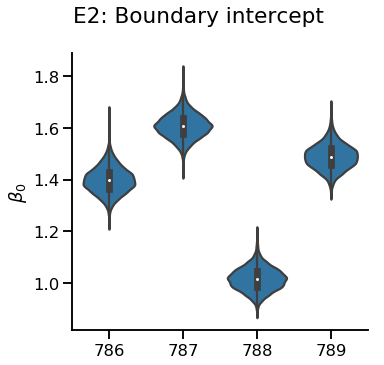

In [369]:
sns.set_context("talk", font_scale=1)

g = sns.FacetGrid(sub_intercept_traces_df_melted.loc[sub_intercept_traces_df_melted.parameter == 'a'], 
                height = 5)
g.map_dataframe(sns.violinplot, x="subj_idx", y = 'intercept').add_legend()

plt.ylabel(r'$\beta_0$')
g.fig.subplots_adjust(top=0.9) 
g.fig.suptitle("\n".join(wrap("E2: Boundary intercept", 60)), y=1.03)
g.savefig(os.path.join(write_dir, 'E2_boundary_intercept.png'))

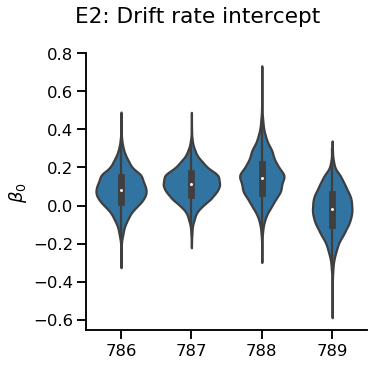

In [370]:
sns.set_context("talk", font_scale=1)

g = sns.FacetGrid(sub_intercept_traces_df_melted.loc[sub_intercept_traces_df_melted.parameter == 'v'], 
                height = 5)
g.map_dataframe(sns.violinplot, x="subj_idx", y = 'intercept').add_legend()

plt.ylabel(r'$\beta_0$')
g.fig.subplots_adjust(top=0.9) 
g.fig.suptitle("\n".join(wrap("E2: Drift rate intercept", 60)), y=1.03)
g.savefig(os.path.join(write_dir, 'E2_drift_intercept.png'))

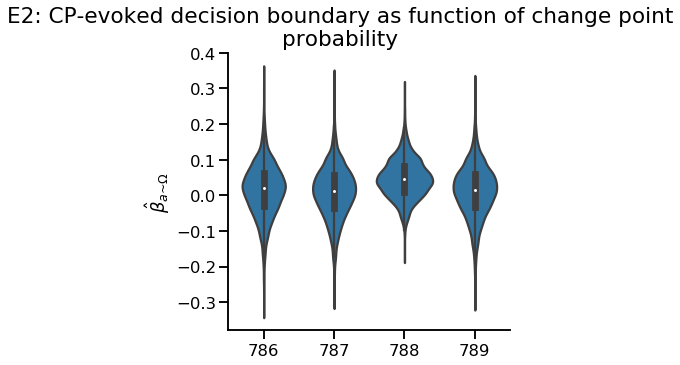

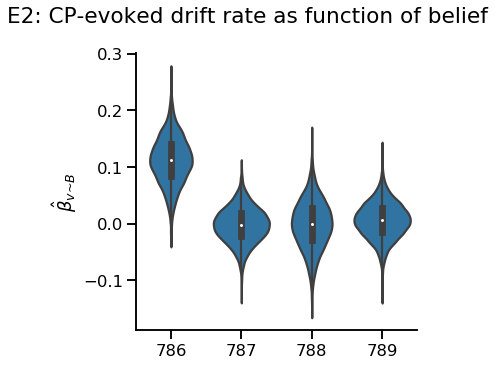

In [372]:
sns.set_context("talk", font_scale=1)

g = sns.FacetGrid(melted_sub_a_cpp_traces, height = 5,
                  )
g.map_dataframe(sns.violinplot, x="subj_idx", y = 'a_cpp_shifted').add_legend()

plt.ylabel(r'$\hat{\beta}_{a \textasciitilde \Omega}$')

g.fig.subplots_adjust(top=0.9) 
g.fig.suptitle("\n".join(wrap("E2: CP-evoked decision boundary as function of change point probability", 60)), y=1.03)
g.savefig(os.path.join(write_dir, 'E2_boundary_cpp.png'))

sns.set_context("talk", font_scale=1)

g = sns.FacetGrid(melted_sub_v_B_traces,  height = 5,
                  )
g.map_dataframe(sns.violinplot, x="subj_idx", y = 'v_ideal_B_shifted').add_legend()

plt.ylabel(r'$\hat{\beta}_{v \textasciitilde B}$')
g.fig.subplots_adjust(top=0.9) 
g.fig.suptitle("\n".join(wrap("E2: CP-evoked drift rate as function of belief", 60)), y=1.03)
g.savefig(os.path.join(write_dir, 'E2_drift_B.png'))


In [375]:
write_dir

'/lab_data/coaxlab/Projects/dynamic_decision_policy_reconfiguration/analysis_revision/loki0.5_acc_av_models/subset_regression/'

<Figure size 720x576 with 0 Axes>

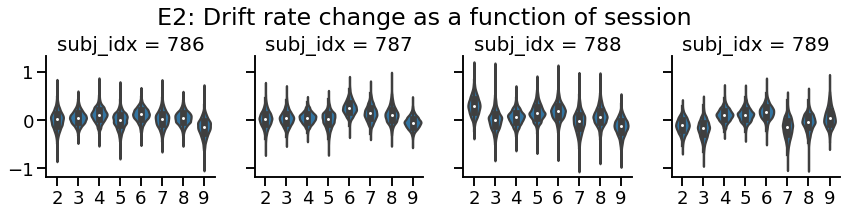

In [373]:
plt.figure(figsize=(10,8))
sns.set_context("talk", font_scale=1.1)

g = sns.FacetGrid(melted_sub_v_session_traces, 
                 col='subj_idx')
g.map_dataframe(sns.violinplot, x="session_n", y='v', alpha=0.3).add_legend()



g.fig.subplots_adjust(top=0.8) 
g.fig.suptitle("\n".join(wrap("E2: Drift rate change as a function of session", 60)), y=1.03)

g.savefig(os.path.join(write_dir, 'E2_drift_session.png'))


<Figure size 720x576 with 0 Axes>

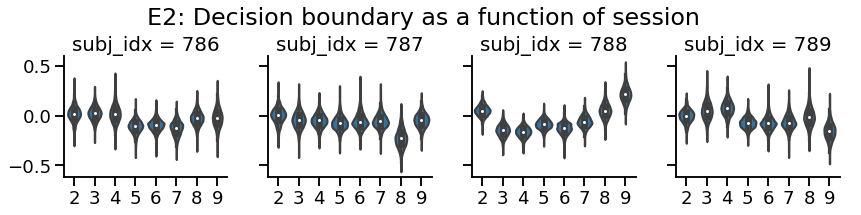

In [374]:
plt.figure(figsize=(10,8))
sns.set_context("talk", font_scale=1.1)

g = sns.FacetGrid(melted_sub_a_session_traces, 
                 col='subj_idx')
g.map_dataframe(sns.violinplot, x="session_n", y='a', alpha=0.3).add_legend()



g.fig.subplots_adjust(top=0.8) 
g.fig.suptitle("\n".join(wrap("E2: Decision boundary as a function of session", 60)), y=1.03)
g.savefig(os.path.join(write_dir, 'E2_bound_session.png'))


In [336]:
# plt.figure(figsize=(10,8))
# sns.set_context("talk", font_scale=1)

# g = sns.FacetGrid(melted_sub_v_B_traces, 
#                   col="subj_idx")
# g.map_dataframe(plt.hist, x="v_ideal_B_shifted").add_legend()

# g.fig.text(0.5,0,r'$\hat{\beta}_{v \textasciitilde B}$')
# g.fig.subplots_adjust(top=0.8) 
# g.fig.suptitle("\n".join(wrap("E2: CP-evoked drift rate as function of belief", 60)), y=1.03)

In [335]:
# plt.figure(figsize=(10,8))
# sns.set_context("talk", font_scale=1)

# g = sns.FacetGrid(melted_sub_a_cpp_traces, 
#                   col="subj_idx")
# g.map_dataframe(plt.hist, x="a_cpp_shifted").add_legend()

# g.fig.text(0.5,0,r'$\hat{\beta}_{a \textasciitilde \Omega}$')
# g.fig.subplots_adjust(top=0.6) 
# g.fig.suptitle("\n".join(wrap("E2: CP-evoked decision boundary as function of change point probability", 60)), y=1.03)

In [334]:
# plt.figure(figsize=(10,8))
# sns.set_context("talk", font_scale=1)

# g = sns.FacetGrid(melted_sub_a_session_traces, 
#                   col="subj_idx", hue="session_n")
# g.map_dataframe(plt.hist, x="a", alpha=0.3).add_legend()


# g.fig.subplots_adjust(top=0.8) 
# g.fig.suptitle("\n".join(wrap("E2: Boundary change as a function of session", 60)), y=1.03)

In [333]:
# plt.figure(figsize=(10,8))
# sns.set_context("talk", font_scale=1.1)
# plt.title("\n".join(wrap("E2: Boundary change as a function of session", 60)), y=1.03)

# for trace in sub_a_session_traces: 
#     plt.hist(sub_a_session_traces[trace], alpha=0.6, label=trace)
#     plt.axvline(x=0, color='black')
#     plt.xlabel(r'$\hat{\beta}_{a \textasciitilde session}$')
#     sns.despine(bottom=True, left=True)
#     plt.legend()

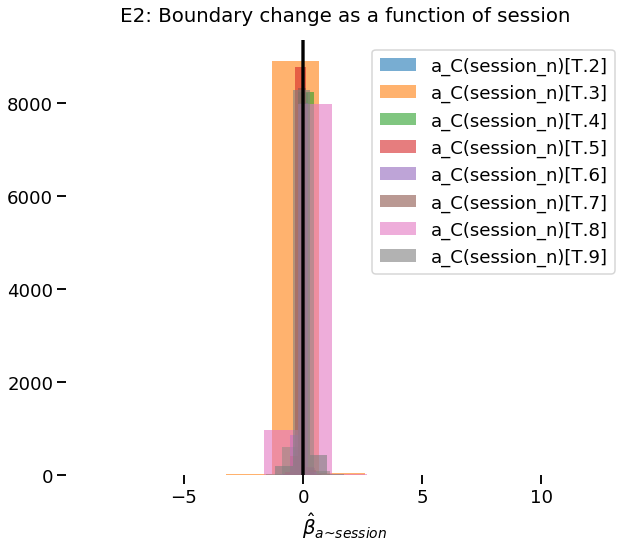

In [128]:
plt.figure(figsize=(10,8))
sns.set_context("talk", font_scale=1.1)
plt.title("\n".join(wrap("E2: Boundary change as a function of session", 60)), y=1.03)

for trace in grp_a_session_traces: 
    plt.hist(grp_a_session_traces[trace], alpha=0.6, label=trace)
    plt.axvline(x=0, color='black')
    plt.xlabel(r'$\hat{\beta}_{a \textasciitilde session}$')
    sns.despine(bottom=True, left=True)
    plt.legend()

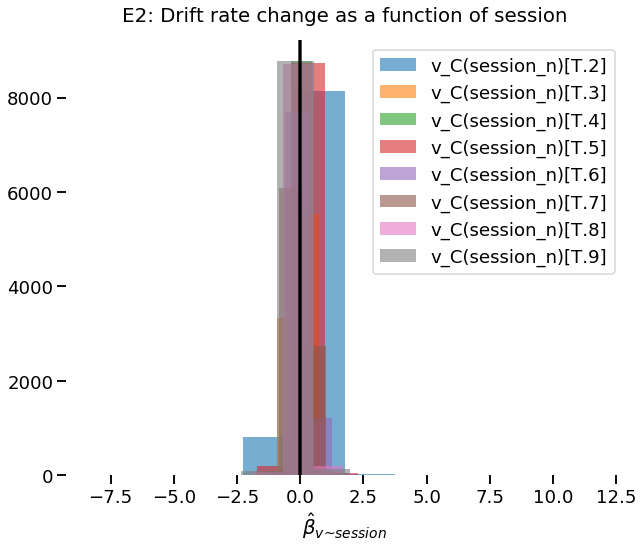

In [129]:
plt.figure(figsize=(10,8))
sns.set_context("talk", font_scale=1.1)
plt.title("\n".join(wrap("E2: Drift rate change as a function of session", 60)), y=1.03)

for trace in grp_v_session_traces: 
    plt.hist(grp_v_session_traces[trace], alpha=0.6, label=trace)
    plt.axvline(x=0, color='black')
    plt.xlabel(r'$\hat{\beta}_{v \textasciitilde session}$')
    sns.despine(bottom=True, left=True)
    plt.legend()

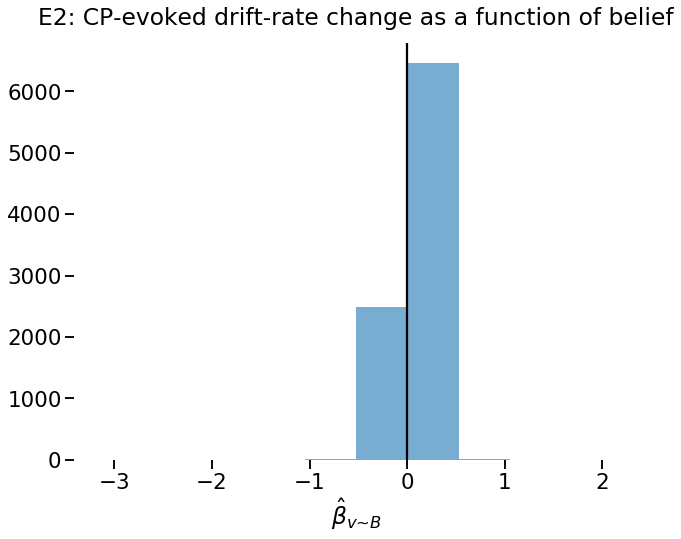

In [115]:
plt.figure(figsize=(10,8))
sns.set_context("talk", font_scale=1.3)
plt.hist(a_cpp_v_B_all_subs['v_ideal_B_shifted'], alpha=0.6)
plt.xlabel(r'$\hat{\beta}_{v \textasciitilde B}$')
plt.axvline(x=0, color='black')
sns.despine(bottom=True, left=True)
plt.title("\n".join(wrap("E2: CP-evoked drift-rate change as a function of belief", 60)), y=1.03)

plt.tight_layout()
plt.savefig(os.path.join(write_dir, 'CP_evoked_drift_beta_posterior.pdf'), bbox_inches='tight')

### Calculating an estimate of trialwise decision parameters using group-level $\hat{\beta}$

In [31]:
len(all_obs_data_pared); len()

4121

In [32]:
grp_a_estimate = a_cpp_v_B_all_subs['a_Intercept'].mean() + a_cpp_v_B_all_subs['a_cpp_shifted'].mean() * all_obs_data_pared.cpp_shifted.values
grp_v_estimate = a_cpp_v_B_all_subs['v_Intercept'].mean() + a_cpp_v_B_all_subs['v_ideal_B_shifted'].mean() * all_obs_data_pared.ideal_B_shifted.values

In [33]:
all_obs_data_pared['grp_a_estimate'] = grp_a_estimate
all_obs_data_pared['grp_v_estimate'] = grp_v_estimate

### Calculating an estimate of trialwise decision parameters for each subject using sub-level $\hat{\beta_0}$ & group-level $\hat{\beta}$

In [37]:
for s in all_obs_data_pared.subj_idx.unique():
    
    print(s)
    
    dat = all_obs_data_pared.loc[all_obs_data_pared.subj_idx == s].copy().reset_index(drop=True)
    
    sub_a_estimate = a_cpp_v_B_all_subs['a_Intercept_subj.{}'.format(s)].mean() + a_cpp_v_B_all_subs['a_cpp_shifted'].mean() * dat.cpp_shifted
    sub_v_estimate = a_cpp_v_B_all_subs['v_Intercept_subj.{}'.format(s)].mean() + a_cpp_v_B_all_subs['v_ideal_B_shifted'].mean() * dat.ideal_B_shifted
    
    
    all_obs_data_pared.loc[all_obs_data_pared.subj_idx == s, 
                                'sub_a_estimate'] = sub_a_estimate.values
    
    all_obs_data_pared.loc[all_obs_data_pared.subj_idx == s, 
                                'sub_v_estimate'] = sub_v_estimate.values
    
assert all_obs_data_pared.sub_v_estimate.isna().sum() == 0, 'check v estimate'
assert all_obs_data_pared.sub_a_estimate.isna().sum() == 0, 'check a estimate'

786
787
788
789


In [39]:
all_obs_data_pared.head()

,response,rt,reward_code,subj_idx,condition,ideal_B,cpp,shifted_epoch_trial,cpp_shifted,ideal_B_shifted,grp_a_estimate,grp_v_estimate,sub_a_estimate,sub_v_estimate
1,1.0,0.500100,0,786,6510,-1.562444,0.319389,2.0,0.076938,-2.160816,1.419050,0.034884,1.353472,0.014903
2,1.0,0.534169,0,786,6510,0.125126,0.300755,3.0,0.319389,-1.562444,1.422023,0.050702,1.356445,0.030721
3,1.0,0.630004,0,786,6510,2.206471,0.077553,-1.0,0.300755,0.125126,1.421795,0.095313,1.356217,0.075332
4,1.0,0.596382,0,786,6510,-2.664951,0.463273,0.0,0.077553,2.206471,1.419058,0.150334,1.353480,0.130352
5,1.0,0.530803,0,786,6510,-0.102781,0.075790,1.0,0.463273,-2.664951,1.423788,0.021557,1.358210,0.001576


# Group-level CP-evoked responses 

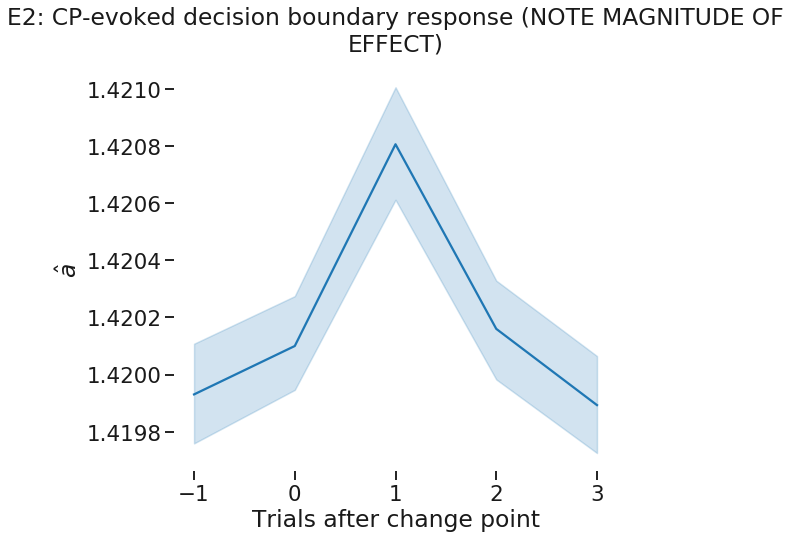

In [41]:
plt.figure(figsize=(10,8))
sns.set_context("talk", font_scale=1.3)

sns.lineplot(x='shifted_epoch_trial', y='grp_a_estimate', data=all_obs_data_pared)
plt.xlabel('Trials after change point')
plt.ylabel(r'$\hat{a}$')
plt.title("\n".join(wrap("E2: CP-evoked decision boundary response (NOTE MAGNITUDE OF EFFECT)", 60)), y=1.03)

sns.despine(bottom=True, left=True)
plt.tight_layout()
plt.savefig(os.path.join(write_dir, 'CP_evoked_boundary_trialwise_estimate.pdf'), bbox_inches='tight')

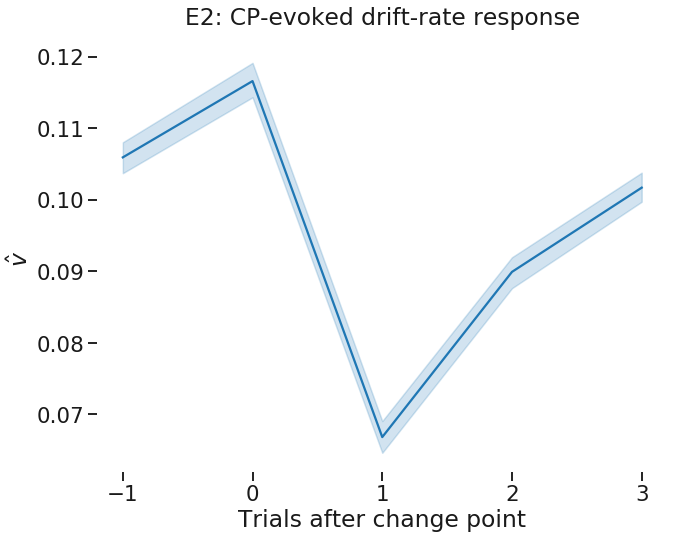

In [43]:
plt.figure(figsize=(10,8))
sns.set_context("talk", font_scale=1.3)

plt.title("\n".join(wrap("E2: CP-evoked drift-rate response", 60)), y=1.03)

sns.lineplot(x='shifted_epoch_trial', y='grp_v_estimate', data=all_obs_data_pared)
plt.xlabel('Trials after change point')
plt.ylabel(r'$\hat{v}$')

sns.despine(bottom=True, left=True)
plt.tight_layout()
plt.savefig(os.path.join(write_dir, 'CP_evoked_drift_trialwise_estimate.pdf'), bbox_inches='tight')

# Sub-level CP-evoked responses 

<Figure size 720x576 with 0 Axes>

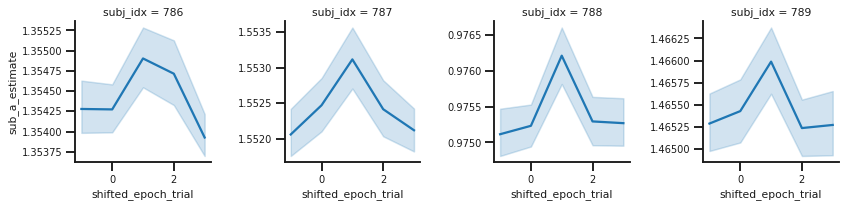

<Figure size 432x288 with 0 Axes>

In [54]:
plt.figure(figsize=(10,8))
sns.set_context("talk", font_scale=0.6)

g = sns.FacetGrid(all_obs_data_pared, col="subj_idx", col_wrap=4, sharey=False,despine=True)
g.map(sns.lineplot, "shifted_epoch_trial","sub_a_estimate")
plt.show()
g.despine(bottom=True, left=True)
plt.tight_layout()

# g.fig.subplots_adjust(top=0.9) # adjust the Figure in rp
# g.fig.suptitle('Experiment 2')

<Figure size 720x576 with 0 Axes>

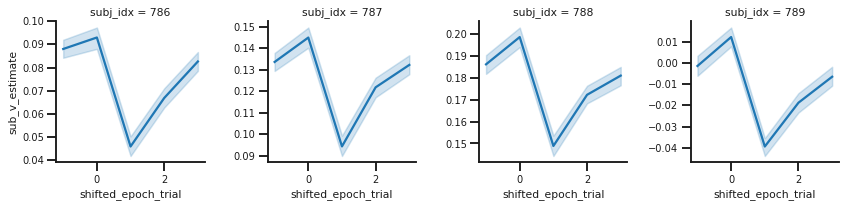

<Figure size 432x288 with 0 Axes>

In [50]:
plt.figure(figsize=(10,8))
sns.set_context("talk", font_scale=0.6)

g = sns.FacetGrid(all_obs_data_pared, col="subj_idx", col_wrap=4, sharey=False, despine=True)
g.map(sns.lineplot, "shifted_epoch_trial","sub_v_estimate")
plt.show()

g.despine(bottom=True, left=True)
plt.tight_layout()

# Convergence looks okay. 

Plotting t
Plotting t_std
Plotting a_Intercept
Plotting a_Intercept_std
Plotting a_cpp_shifted
Plotting v_Intercept
Plotting v_Intercept_std
Plotting v_ideal_B_shifted


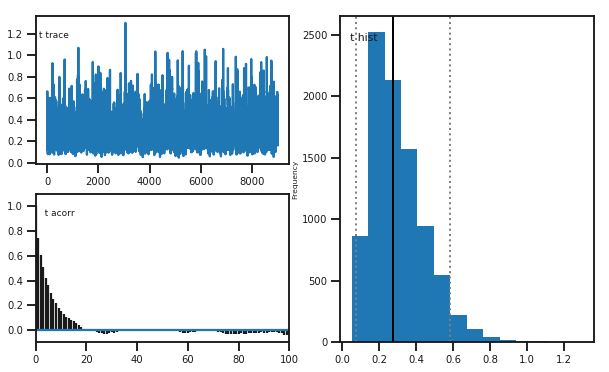

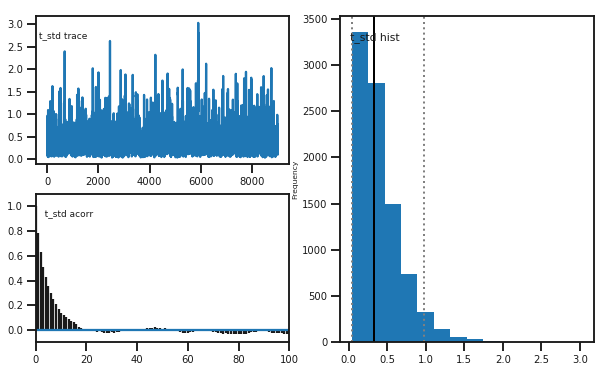

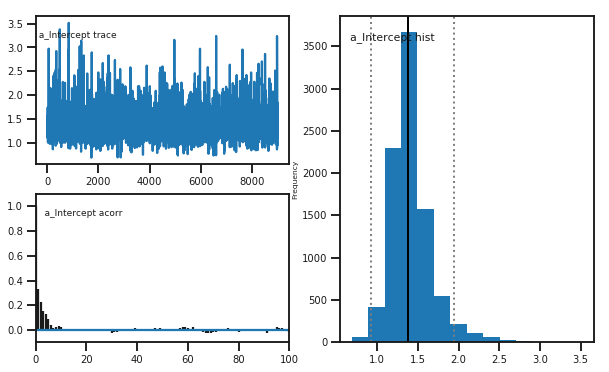

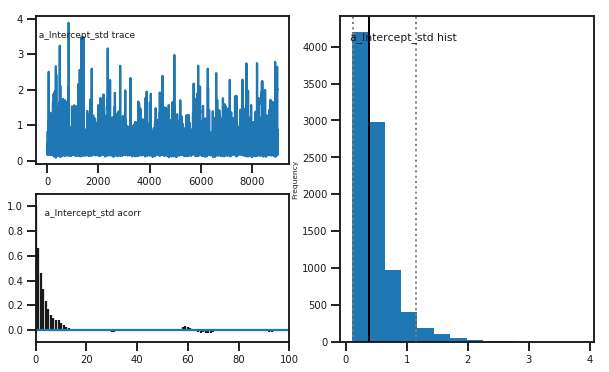

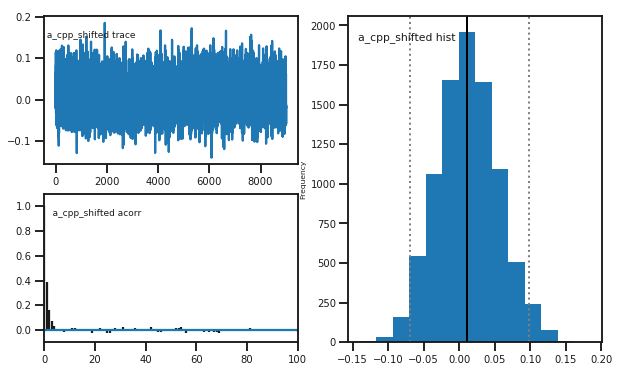

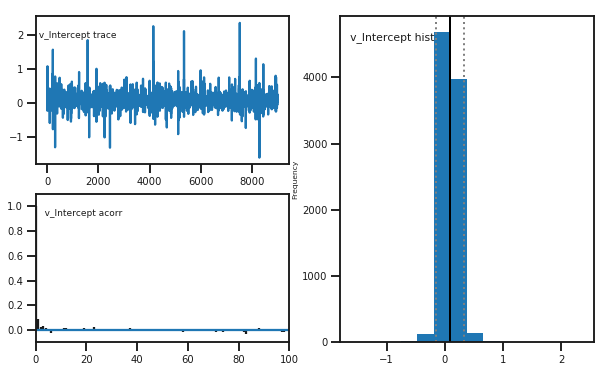

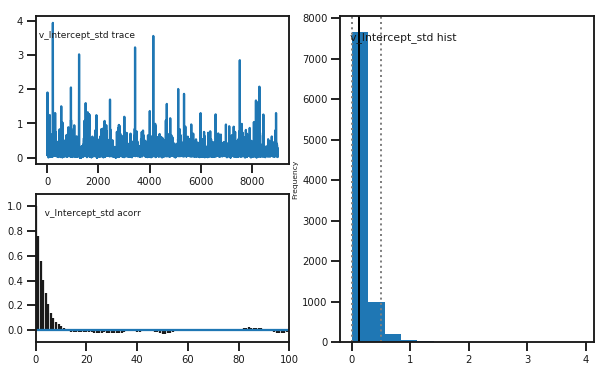

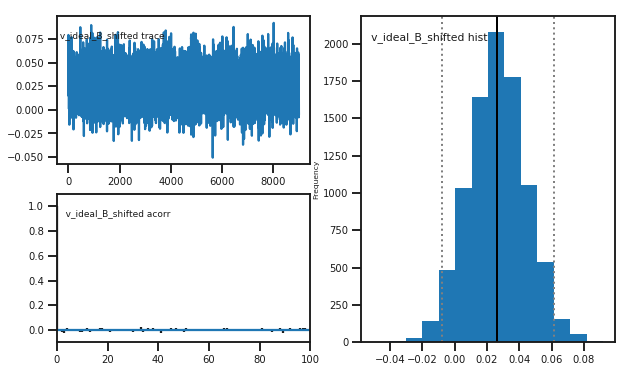

In [235]:
a_cpp_v_B_all_subs.plot_posteriors()

In [22]:
subj_df_list = []

for model in model_dict:
    for subject in range(len(subjects)):
        subj_df = model_dict[model][subject].get_traces()
        subj_df['subj_idx'] = model_dict[model][subject].data.subj_idx.unique().tolist() * n_effective_samples
        subj_df['model'] = model
        subj_df['dic'] = model_dict[model][subject].dic
        subj_df_list.append(subj_df)
    
subj_df_all = pd.concat(subj_df_list, sort=True)

In [23]:
len(subj_df_list) == (len(subjects) * n_models)

True

In [24]:
len(subj_df_all) == (len(subjects)*n_models*n_effective_samples)

True

In [25]:
subj_df_all.head()

,a_Intercept,a_cpp_shifted,a_ideal_B_shifted,dic,model,subj_idx,t,v_Intercept,v_cpp_shifted,v_ideal_B_shifted
0,1.361914,NaN,NaN,1153.633374,intercept,786,0.123495,0.100358,NaN,NaN
1,1.363225,NaN,NaN,1153.633374,intercept,786,0.122285,0.077018,NaN,NaN
2,1.369444,NaN,NaN,1153.633374,intercept,786,0.122773,0.110424,NaN,NaN
3,1.343195,NaN,NaN,1153.633374,intercept,786,0.122471,0.064577,NaN,NaN
4,1.373429,NaN,NaN,1153.633374,intercept,786,0.122610,0.118137,NaN,NaN


In [36]:
a_cpp_v_B_dat = subj_df_all.loc[subj_df_all.model == 'a_cpp_v_B']

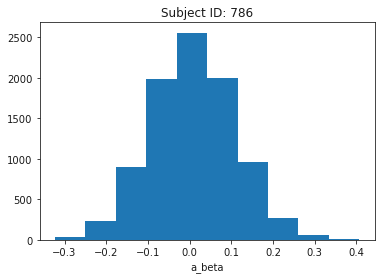

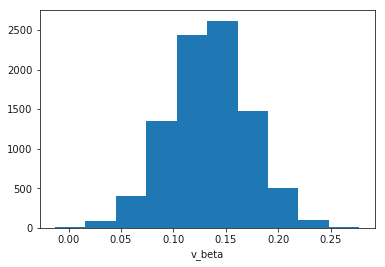

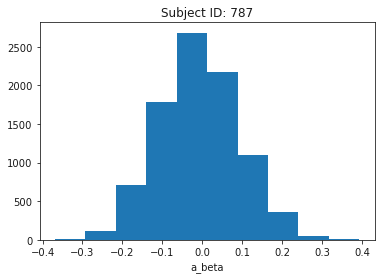

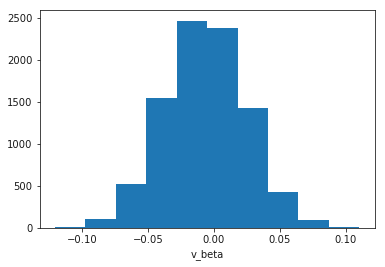

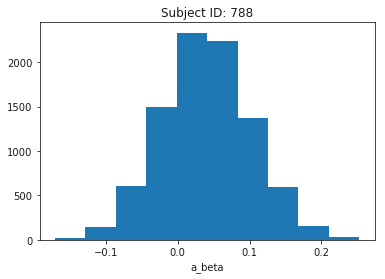

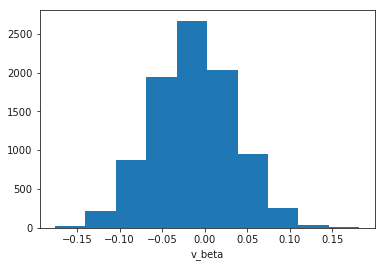

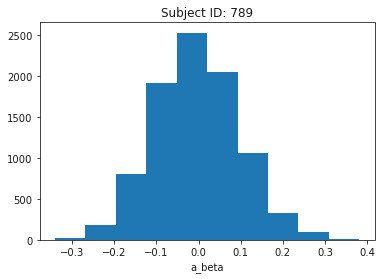

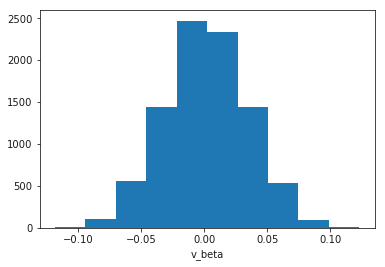

In [42]:
%matplotlib inline

for s in a_cpp_v_B_dat.subj_idx.unique():

    dat = a_cpp_v_B_dat.loc[a_cpp_v_B_dat.subj_idx ==s].copy()
    
    plt.figure()
    plt.title('Subject ID: {}'.format(s))
    plt.hist(dat.a_cpp_shifted)
    plt.xlabel('a_beta')
    plt.figure()
    plt.hist(dat.v_ideal_B_shifted)
    plt.xlabel('v_beta')


In [26]:
subj_df_all.model.unique()

array(['intercept', 'v_cpp_a_B', 'a_cpp_v_B'], dtype=object)

In [27]:
subj_df_all.groupby(['subj_idx', 'model'])['dic'].unique()

subj_idx  model    
786       a_cpp_v_B    [1145.1960668751506]
          intercept     [1153.633373852404]
          v_cpp_a_B     [1153.348589860476]
787       a_cpp_v_B    [1728.7434132348442]
          intercept    [1724.7891551925668]
          v_cpp_a_B    [1720.6099305801572]
788       a_cpp_v_B     [49.55651188061135]
          intercept     [45.99106398805974]
          v_cpp_a_B    [49.713598040052354]
789       a_cpp_v_B     [1528.559526525405]
          intercept    [1524.6451483520314]
          v_cpp_a_B    [1528.2158673945512]
Name: dic, dtype: object

In [28]:
dics_df = (subj_df_all.groupby(['subj_idx', 'model'])['dic'].unique() - subj_df_all.loc[subj_df_all.model == 'intercept'].groupby(['subj_idx'])['dic'].unique()).reset_index()

In [29]:
dics_df['raw_dic'] = subj_df_all.groupby(['subj_idx', 'model'])['dic'].unique().reset_index()['dic']

In [30]:
dics_df = dics_df.rename(index=str, columns={"dic": "null_adj_dic"})
dics_df['null_adj_dic'] = dics_df['null_adj_dic'].str[0]
dics_df['raw_dic'] = dics_df['raw_dic'].str[0]

In [31]:
dics_df.head()

,subj_idx,model,null_adj_dic,raw_dic
0,786,a_cpp_v_B,-8.437307,1145.196067
1,786,intercept,0.000000,1153.633374
2,786,v_cpp_a_B,-0.284784,1153.348590
3,787,a_cpp_v_B,3.954258,1728.743413
4,787,intercept,0.000000,1724.789155


In [32]:
dics_df

,subj_idx,model,null_adj_dic,raw_dic
0,786,a_cpp_v_B,-8.437307,1145.196067
1,786,intercept,0.000000,1153.633374
2,786,v_cpp_a_B,-0.284784,1153.348590
3,787,a_cpp_v_B,3.954258,1728.743413
4,787,intercept,0.000000,1724.789155
5,787,v_cpp_a_B,-4.179225,1720.609931
6,788,a_cpp_v_B,3.565448,49.556512
7,788,intercept,0.000000,45.991064
8,788,v_cpp_a_B,3.722534,49.713598
9,789,a_cpp_v_B,3.914378,1528.559527


In [33]:
subj_df_all.to_csv(os.path.join(home, 'analysis_revision/models/', 'all_model_data_loki_0.5.csv'))

In [34]:
dics_df.to_csv(os.path.join(home, 'analysis_revision/models/', 'dic_model_data_loki_0.5.csv'))